- Book: Modern Computer Vision with PyTorch (by V Kishore Ayyadevara)

In [1]:
# Libraries
import torchvision
import torch.nn as nn
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models, datasets
from PIL import Image
from torch import optim
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import cv2, glob, numpy as np, pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.ticker as mticker
%matplotlib inline
from glob import glob
from random import shuffle, seed; seed(10);

In [2]:
!pip install torch_summary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!pip install -q kaggle

In [4]:
from torchsummary import summary

In [5]:
# Upload kaggle.json
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"matheuslopesvivas","key":"120f904c2a67a5602edf7b9253c9cc2d"}'}

In [6]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

kaggle.json


In [ ]:
!kaggle datasets download -d tongpython/cat-and-dog
!unzip cat-and-dog.zip

In [8]:
train_data_dir = '/content/training_set/training_set'
test_data_dir = '/content/test_set/test_set'

In [9]:
d = glob('/content/training_set/training_set' + '/cats/*.jpg')
d[:3]

['/content/training_set/training_set/cats/cat.1181.jpg',
 '/content/training_set/training_set/cats/cat.3622.jpg',
 '/content/training_set/training_set/cats/cat.1874.jpg']

In [10]:
class cats_dogs(Dataset):
    def __init__(self, folder):
        cats = glob(folder + '/cats/*.jpg')
        dogs = glob(folder + '/dogs/*.jpg')
        self.fpaths = cats + dogs
        shuffle(self.fpaths) # randomize the file paths
        # Reminder: startswith return True (1) ou False (0)
        self.targets = [fpath.split('/')[-1].startswith('dog')
                        for fpath in self.fpaths] # dog = 1, cat = 0
    def __len__(self):
        return len(self.fpaths)
    def __getitem__(self, ix):
        f = self.fpaths[ix]
        target = self.targets[ix]
        im = (cv2.imread(f)[:,:,::-1])
        im = cv2.resize(im, (224, 224))
        # permute(index 2, index 0, index 1)
        # Creating an index 2 for the channel
        return torch.tensor(im / 255).permute(2, 0, 1).to(device)\
            .float(), torch.tensor([target]).float().to(device)

In [11]:
# Inspecting a Random Image
data = cats_dogs(train_data_dir)
im, label = data[200]

- We need to permute the image we've obtained to our channels last. This is because matplotlib expects an image to have the channels specified after the height and width of the image

tensor([1.], device='cuda:0')

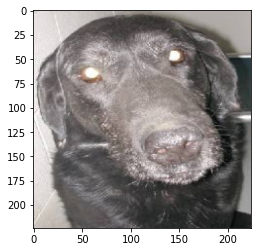

In [12]:
plt.imshow(im.permute(1, 2, 0).cpu())
label

In [13]:
def conv_layer(n_in, n_out, kernel_size, stride = 1):
    return nn.Sequential(
        nn.Conv2d(n_in, n_out, kernel_size, stride),
        nn.ReLU(),
        nn.BatchNorm2d(n_out),
        nn.MaxPool2d(2)
    )

In [14]:
def get_model():
    model = nn.Sequential(
        conv_layer(3, 64, 3),
        conv_layer(64, 512, 3),
        conv_layer(512, 512, 3),
        conv_layer(512, 512, 3),
        conv_layer(512, 512, 3),
        conv_layer(512, 512, 3),
        nn.Flatten(),
        nn.Linear(512, 1),
        nn.Sigmoid(),
    ).to(device)
    loss = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    return model, loss, optimizer

In [15]:
model, loss, optimizer = get_model()
summary(model, torch.zeros(1, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 64, 111, 111]        --
|    └─Conv2d: 2-1                       [-1, 64, 222, 222]        1,792
|    └─ReLU: 2-2                         [-1, 64, 222, 222]        --
|    └─BatchNorm2d: 2-3                  [-1, 64, 222, 222]        128
|    └─MaxPool2d: 2-4                    [-1, 64, 111, 111]        --
├─Sequential: 1-2                        [-1, 512, 54, 54]         --
|    └─Conv2d: 2-5                       [-1, 512, 109, 109]       295,424
|    └─ReLU: 2-6                         [-1, 512, 109, 109]       --
|    └─BatchNorm2d: 2-7                  [-1, 512, 109, 109]       1,024
|    └─MaxPool2d: 2-8                    [-1, 512, 54, 54]         --
├─Sequential: 1-3                        [-1, 512, 26, 26]         --
|    └─Conv2d: 2-9                       [-1, 512, 52, 52]         2,359,808
|    └─ReLU: 2-10                        [-1, 512, 52, 52]        

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 64, 111, 111]        --
|    └─Conv2d: 2-1                       [-1, 64, 222, 222]        1,792
|    └─ReLU: 2-2                         [-1, 64, 222, 222]        --
|    └─BatchNorm2d: 2-3                  [-1, 64, 222, 222]        128
|    └─MaxPool2d: 2-4                    [-1, 64, 111, 111]        --
├─Sequential: 1-2                        [-1, 512, 54, 54]         --
|    └─Conv2d: 2-5                       [-1, 512, 109, 109]       295,424
|    └─ReLU: 2-6                         [-1, 512, 109, 109]       --
|    └─BatchNorm2d: 2-7                  [-1, 512, 109, 109]       1,024
|    └─MaxPool2d: 2-8                    [-1, 512, 54, 54]         --
├─Sequential: 1-3                        [-1, 512, 26, 26]         --
|    └─Conv2d: 2-9                       [-1, 512, 52, 52]         2,359,808
|    └─ReLU: 2-10                        [-1, 512, 52, 52]        

In [16]:
def get_data():
    # drop_last ignores last batch (possible size difference)
    train = cats_dogs(train_data_dir)
    trn_dl = DataLoader(train, batch_size=32, shuffle=True, drop_last=True)
    val = cats_dogs(test_data_dir)
    val_dl = DataLoader(val, batch_size=32, shuffle=True, drop_last=True)
    return trn_dl, val_dl

In [17]:
def train_batch(x, y, model, opt, loss):
    model.train()
    prediction = model(x)
    batch_loss = loss(prediction, y)
    batch_loss.backward()
    opt.step()
    opt.zero_grad()
    return batch_loss.item()

In [18]:
@torch.no_grad()
def accuracy(x, y, model):
    prediction = model(x)
    is_correct = (prediction > 0.5) == y
    return is_correct.cpu().numpy().tolist()

In [19]:
@torch.no_grad()
def val_loss(x, y, model):
    prediction = model(x)
    val_loss = loss(prediction, y)
    return val_loss.item()

In [20]:
trn_dl, val_dl = get_data()

In [22]:
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
for epoch in range(5):
    print(epoch)
    train_epoch_losses, train_epoch_accuracies = [], []
    val_epoch_accuracies = []
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss)
        train_epoch_losses.append(batch_loss)
    train_epoch_loss = np.array(train_epoch_losses).mean()

    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)

    for ix, batch in enumerate(iter(val_dl)):
        x, y = batch
        val_is_correct = accuracy(x, y, model)
        val_epoch_accuracies.extend(val_is_correct)
    val_epoch_accuracy = np.mean(val_epoch_accuracies)

    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_accuracies.append(val_epoch_accuracy)

0
1
2
3
4


In [23]:
np.arange(5) + 1

array([1, 2, 3, 4, 5])

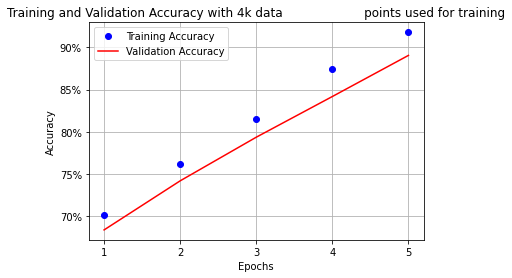

In [24]:
epochs = np.arange(5) + 1
plt.plot(epochs, train_accuracies, 'bo', label='Training Accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation Accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and Validation Accuracy with 4k data \
                    points used for training')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100)
        for x in plt.gca().get_yticks()])
plt.legend()
plt.grid('off')
plt.show()